In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
from glob import glob
import scipy.signal as signal

In [80]:

def filter_timeseries(ts, order, cutoff, btype='lowpass', fs=1, **kwargs):
    """Given an array, this function apply a butterworth (high/low pass) 
    filter of the given order and cutoff frequency.
    For example:
    If 'ts' is a timeseries of daily samples, filter_timeseries(ts,3,1/20)
    will return the series without the 20 days or less variability using an
    order 3 butterworth filter. 
    In the same way, filter_timeseries(ts,3,1/20, btype='highpass') will
    return the series with only the 20 days or less variability.

    Args:
        ts (array_like): timeseries or 1D array to filter
        order (int): _description_
        cutoff (array_like): Single float for lowpass or highpass filters, 
        arraylike for bandpass filters.
        btype (str, optional): The type of filter. Defaults to 'lowpass'.
        fs (int): Sampling frequency. Defaults to 1
        **kwargs are passed to scipy.signal.filtfilt

    Returns:
        output (array): Filtered array
    """
    mask = np.isnan(ts)
    nans = np.ones(len(ts))*np.nan
    if mask.sum()==len(ts):
        return nans
    else:
        b, a = signal.butter(order, cutoff, btype=btype, fs=fs)
        filt=signal.filtfilt(b, a, ts[~mask], **kwargs)
        output=np.ones(len(ts))*np.nan
        output[np.where(~mask)] = filt
        return output
    
def filter_xarray(data, dim, order, cutoff, btype='lowpass', parallel=False, fs=1):
    """Given a 3d DataArray, with time and spatial coordinates, this function apply
    the 1D function filter_timeseries along the time dimension, filter the complete
    xarray data.

    Args:
        data (XDataArray): data
        dim (str): name of the time dimension
        order (int): butterworth filter order
        cutoff (array_like): if float, the cutoff frequency, if array must be the
                            [min,max] frequencys for the bandpass filter.
        btype (str, optional): {lowpass,highpass,bandpass}. Defaults to 'lowpass'.
        parallel (bool, optional): If parallelize with dask. Defaults to False.
        fs (int, optional): Sampling frequency. Defaults to 1.

    Returns:
        XDataArray: filtered data
    """
    if parallel:
        dask='parallelized'
    else:
        dask='forbidden'
    filt = xr.apply_ufunc(filter_timeseries, data, order, cutoff, btype, fs,
                          input_core_dims=[[dim],[],[],[],[]],
                          output_core_dims=[[dim]],
                          exclude_dims=set((dim,)),
                          keep_attrs=True,
                          vectorize=True, dask=dask)
    filt[dim] = data[dim]
    return filt



In [15]:
tropical_glorys_clim       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_tropical_clim.nc')
coastnorth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastnorth_clim.nc')
coastsouth_glorys_clim     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/CLIMATOLOGY/glorys_coastsouth_clim.nc')

tropical_reforecast_clim   = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_tropical_clim.nc')
coastnorth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastnorth_clim.nc')
coastsouth_reforecast_clim = xr.open_dataset('data/S2S/CLIMATOLOGY/reforecasts_coastsouth_clim.nc')

In [10]:
tropical_glorys       = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_tropical.nc').swap_dims({'lon':'index'}).convert_calendar('noleap', dim='time')
tropical_reforecast   = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_tropical.nc').swap_dims({'lon':'index'}).convert_calendar('noleap', dim='inittime')

coastnorth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastnorth.nc').swap_dims({'lat':'index'}).convert_calendar('noleap', dim='time')
coastnorth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastnorth.nc').swap_dims({'lat':'index'}).convert_calendar('noleap', dim='inittime')

coastsouth_glorys     = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/glorys_coastsouth.nc').swap_dims({'lat':'index'}).convert_calendar('noleap', dim='time')
coastsouth_reforecast = xr.open_dataset('data/S2S/HOVMOLLERS/reforecasts_coastsouth.nc').swap_dims({'lat':'index'}).convert_calendar('noleap', dim='inittime')

---

#### climatology checks

In [161]:
tropical_reforecast.groupby()

<xarray.Dataset>
Dimensions:   (inittime: 6155, leadtime: 46, index: 61)
Coordinates:
  * leadtime  (leadtime) int64 0 1 2 3 4 5 6 7 8 ... 37 38 39 40 41 42 43 44 45
    lon       (index) float32 220.0 221.0 222.0 223.0 ... 278.0 279.0 280.0
  * inittime  (inittime) object 2000-01-07 00:00:00 ... 2021-12-16 00:00:00
  * index     (index) int64 0 1 2 3 4 5 6 7 8 9 ... 52 53 54 55 56 57 58 59 60
Data variables:
    zos       (inittime, leadtime, index) float32 0.2443 0.2372 ... 0.2364
    T300      (inittime, leadtime, index) float32 290.0 289.9 ... 287.8 288.0

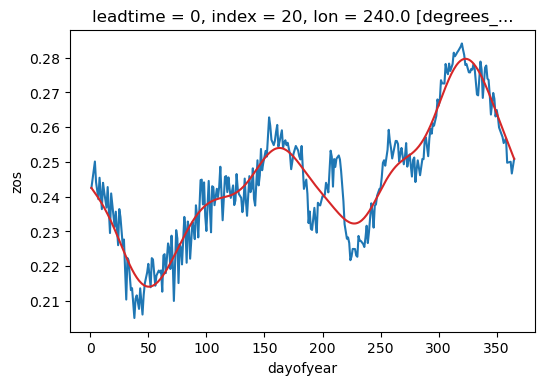

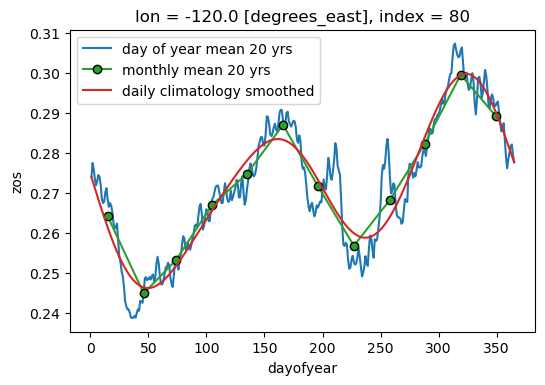

In [43]:
fig = plt.figure(facecolor='w', dpi=100)
ax = fig.add_subplot(111)

tropical_reforecast.zos.sel(index=20,leadtime=0).groupby('inittime.dayofyear').mean().plot()
tropical_reforecast_clim.zos.sel(index=20,leadtime=0).plot(ax=ax, color='tab:red')


plt.figure(facecolor='w', dpi=100)
tropical_glorys.zos.sel(index=80).groupby('time.dayofyear').mean().plot(label='day of year mean 20 yrs ')
clim2=tropical_glorys.zos.sel(index=80).groupby('time.month').mean()
clim2.coords['dayofyear'] = ('month',np.array([15,46,74,105,135,166,196,227,258,288,319,349]))
clim2.plot(x='dayofyear', marker='o', markeredgecolor='k', color='tab:green', label='monthly mean 20 yrs')
filter_xarray(tropical_glorys.zos.sel(index=80).groupby('time.dayofyear').mean(),'dayofyear',5,1/100).plot(color='tab:red', label='daily climatology smoothed')
plt.legend()

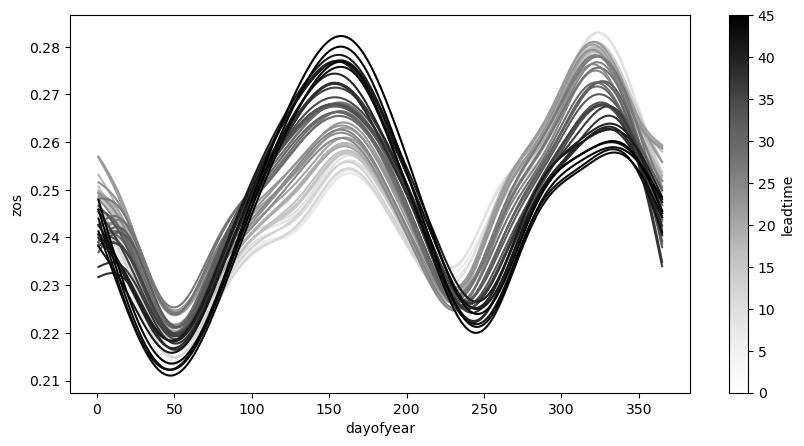

In [44]:
fig = plt.figure(facecolor='w', dpi=100, figsize=(10,5))
ax = fig.add_subplot(111)
y = tropical_reforecast_clim.zos.sel(index=20)

colors=plt.cm.Greys(np.linspace(0.15,1, len(y.leadtime)))
for i,lead in enumerate(y.leadtime):
    y.sel(leadtime=lead).plot(color=colors[i], ax=ax)
    ax.set_title('')
m = plt.cm.ScalarMappable(cmap='Greys', norm=mcolors.Normalize(0,45))
fig.colorbar(m, label='leadtime')


---

##### check forecast for some study cases

In [153]:
itime = '2015-04-09'
ftime = (pd.to_datetime(itime)+pd.Timedelta(days=46)).strftime('%F')

In [53]:
north_glorys = xr.concat([tropical_glorys.zos.drop('lon').groupby('time.dayofyear')-tropical_glorys_clim.zos.drop('lon'),
                          coastnorth_glorys.zos.drop('lat').groupby('time.dayofyear')-coastnorth_glorys_clim.zos.drop('lat')
                         ],'index')

south_glorys = xr.concat([tropical_glorys.zos.drop('lon').groupby('time.dayofyear')-tropical_glorys_clim.zos.drop('lon'),
                          coastsouth_glorys.zos.drop('lat').groupby('time.dayofyear')-coastsouth_glorys_clim.zos.drop('lat')
                         ],'index')

In [133]:
north_reforecast = xr.concat([tropical_reforecast.zos.drop('lon').groupby('inittime.dayofyear')-tropical_reforecast_clim.zos.drop('lon'),
                          coastnorth_reforecast.zos.drop('lat').groupby('inittime.dayofyear')-coastnorth_reforecast_clim.zos.drop('lat')
                         ],'index')

south_reforecast = xr.concat([tropical_reforecast.zos.drop('lon').groupby('inittime.dayofyear')-tropical_reforecast_clim.zos.drop('lon'),
                          coastsouth_reforecast.zos.drop('lat').groupby('inittime.dayofyear')-coastsouth_reforecast_clim.zos.drop('lat')
                         ],'index')

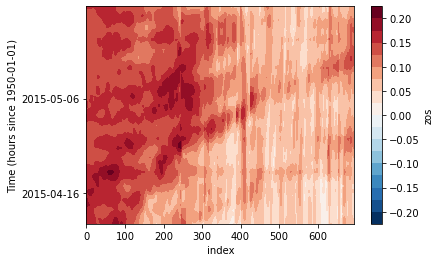

In [154]:
south_glorys.sel(time=slice(itime,ftime)).plot.contourf(levels=20, x='index', y='time', cmap='RdBu_r')

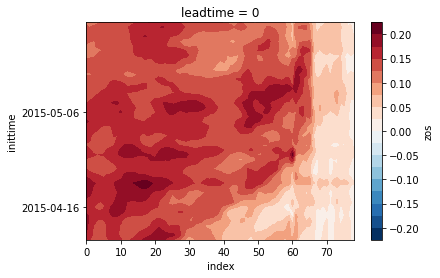

In [155]:
south_reforecast.sel(leadtime=0).sel(inittime=slice(itime,ftime)).squeeze().plot.contourf(levels=20, x='index', y='inittime', cmap='RdBu_r')